In [ ]:
# ── universal run-folder resolver ─────────────────────────────────────
from pathlib import Path
import os, yaml

CFG_FILE = Path(os.getenv("PIPELINE_CFG", "pipeline_config.yaml")).expanduser()
CFG = yaml.safe_load(CFG_FILE.read_text()) or {}
DEFAULTS = CFG.get("defaults", {})
EVENTS   = {str(k): v for k, v in CFG.get("events", {}).items()}

SWAN_YEAR = str(os.getenv("SWAN_YEAR", next(iter(EVENTS))))
OUTPUT_ROOT = Path(DEFAULTS["OUTPUT_ROOT"]).expanduser()
EVENT_DIR   = OUTPUT_ROOT / f"event={SWAN_YEAR}"

RUN_DIR = (Path(os.getenv("RUN_DIR")).expanduser()
           if os.getenv("RUN_DIR") else
           (EVENT_DIR / os.getenv("RUN_DATE") if os.getenv("RUN_DATE")
            else max(EVENT_DIR.iterdir(), key=lambda p: p.stat().st_mtime)))

print(f"[bootstrap] RUN_DIR = {RUN_DIR}")
# make the variable visible to the rest of the notebook
globals()["RUN_DIR"] = RUN_DIR
# ──────────────────────────────────────────────────────────────────────


Summary Statistics for Overall:
  RISE_Score: mean=2.286, median=2.292, std=0.490, min=1.000, max=3.625, count=34862
  Physical_Score: mean=2.230, median=2.333, std=0.721, min=1.000, max=5.000, count=34449
  Information_Score: mean=2.059, median=2.000, std=0.609, min=1.000, max=4.000, count=33384
  Cognitive_Score: mean=2.204, median=2.333, std=1.055, min=1.000, max=4.500, count=34862
  Social_Score: mean=2.744, median=2.750, std=0.780, min=1.000, max=5.000, count=34517
  Prepare_Score: mean=2.063, median=2.333, std=0.617, min=1.000, max=4.000, count=34484
  Absorb_Score: mean=1.620, median=1.750, std=0.571, min=1.000, max=4.000, count=34660
  Recover_Score: mean=2.573, median=2.500, std=0.597, min=1.000, max=5.000, count=34484
  Adapt_Score: mean=2.918, median=2.750, std=0.756, min=1.000, max=5.000, count=34862

Summary Statistics for Portfolio Stocks:
  RISE_Score: mean=2.674, median=2.771, std=0.340, min=1.000, max=3.604, count=339
  Physical_Score: mean=2.854, median=3.000, std=0.

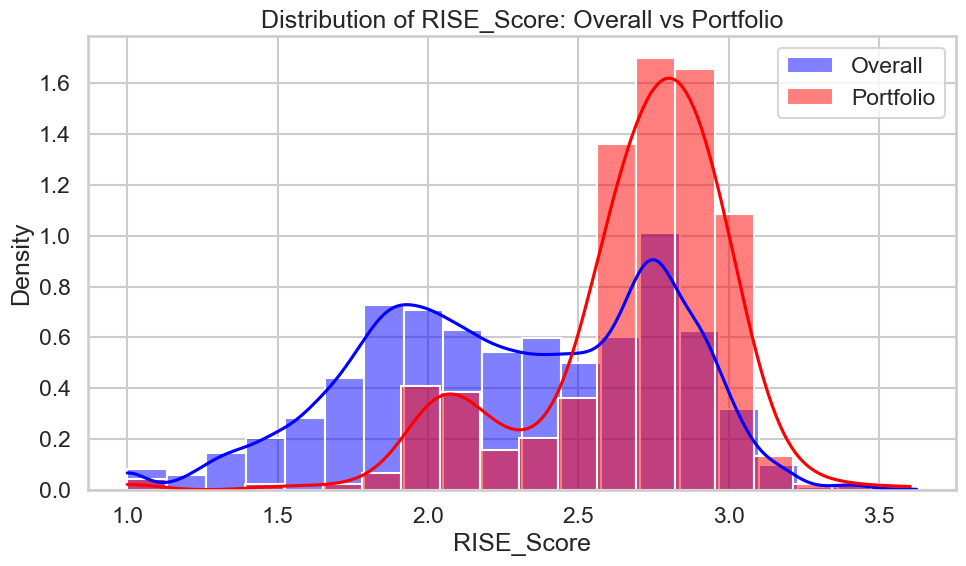

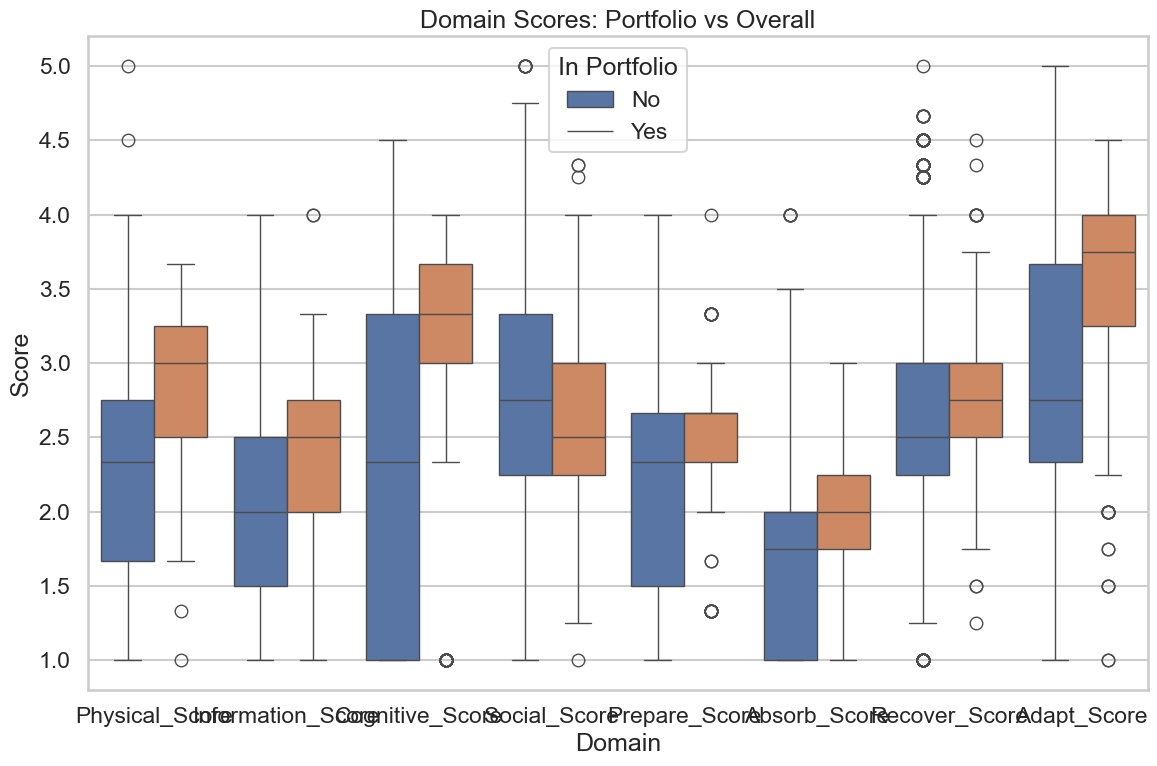

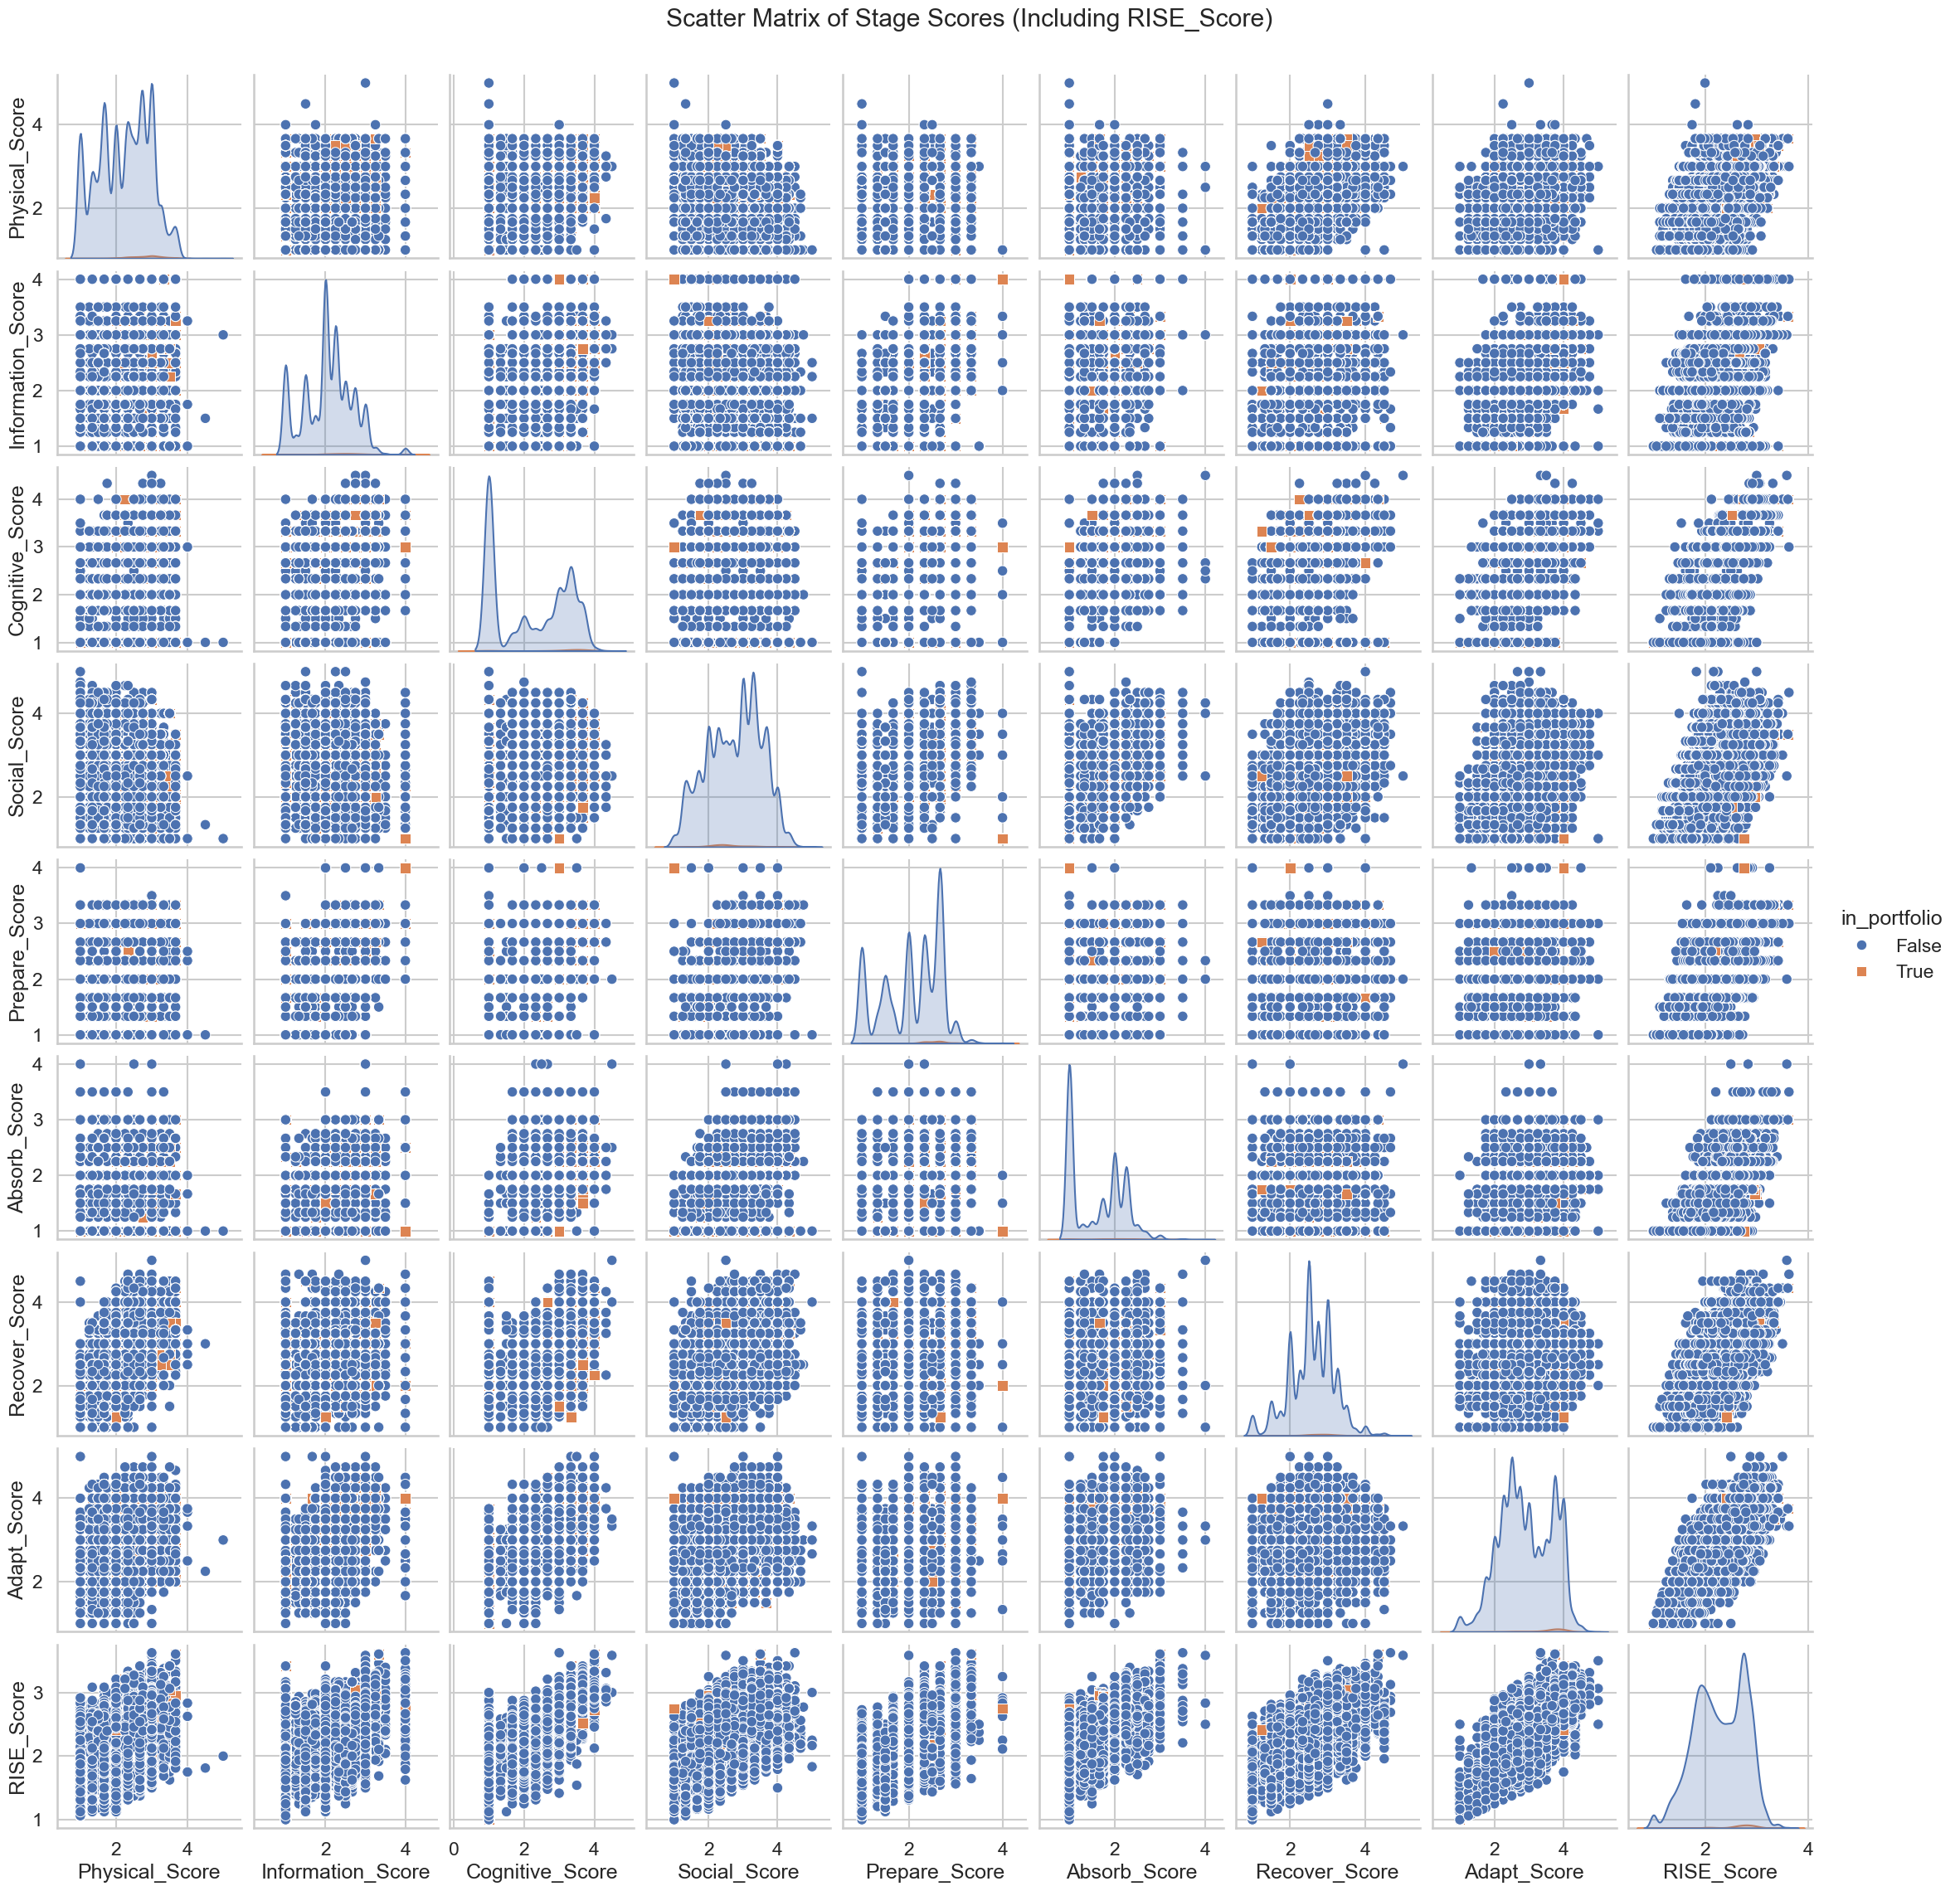


Average Domain Scores by Group:
        Group  Physical_Score  Information_Score  Cognitive_Score  Social_Score  Prepare_Score  Absorb_Score  Recover_Score  Adapt_Score
Non-Portfolio        2.223741           2.056342         2.196053      2.745485       2.058040      1.617886       2.570390     2.912541
    Portfolio        2.854291           2.287788         3.057030      2.608309       2.536816      1.885169       2.788557     3.523107

Dashboard summary saved to: C:\Users\Jason Pohl\OneDrive - Bond University\PhD\rff\outputs_rff\event=2008\20250609\stage05a\Stage23_PortfolioSummary.csv

Portfolio RISE_Score per year, t-stat, p-value (vs rest), and mean (2007-2009):


,Symbol,Name,2007_RISE,2007_tstat,2007_pval,2008_RISE,2008_tstat,2008_pval,2009_RISE,2009_tstat,2009_pval,Mean_2007_2009
0,ALL,ALL,nan,nan,nan,2.917,nan,nan,2.792,nan,nan,2.854
1,AMP,AMP,nan,nan,nan,2.500,nan,nan,2.312,nan,nan,2.406
2,ANZ,ANZ,nan,nan,nan,2.979,nan,nan,2.854,nan,nan,2.917
3,BHP,BHP,2.896,nan,nan,2.979,nan,nan,2.917,nan,nan,2.931
4,BXB,BXB,nan,nan,nan,2.917,nan,nan,2.917,nan,nan,2.917
5,CBA,CBA,2.979,nan,nan,3.042,nan,nan,3.042,nan,nan,3.021
6,COH,COH,2.854,nan,nan,2.854,nan,nan,2.792,nan,nan,2.833
7,IRE,IRE,2.688,nan,nan,2.771,nan,nan,2.771,nan,nan,2.743
8,JBH,JBH,2.646,nan,nan,nan,nan,nan,nan,nan,nan,2.646
9,MQG,MQG,nan,nan,nan,3.604,nan,nan,3.333,nan,nan,3.469


In [ ]:
#!/usr/bin/env python
"""
Stage 23: Portfolio Comparison Dashboard

Compares a user-specified portfolio to the rest of the market using Stage 5A output.
Summary statistics, visualizations, and group-level domain comparisons are produced and shown.
"""

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Configuration
# -------------------------------
SWAN_YEAR = os.getenv("SWAN_YEAR", "2008")
RUN_DATE  = os.getenv("RUN_DATE", "20250609")
OUTPUT_ROOT = Path("C:/Users/Jason Pohl/OneDrive - Bond University/PhD/rff/outputs_rff")
stage05a_dir = OUTPUT_ROOT / f"event={SWAN_YEAR}" / RUN_DATE / "stage05a"
scores_csv   = stage05a_dir / "Stage5A_QuintilesAndScores.csv"

if not scores_csv.is_file():
    raise FileNotFoundError(f"Stage 5A file not found at {scores_csv}")

# Portfolio tickers (updated to your provided list)
portfolio_tickers = [
    "RIO","ANZ","BXB","BHP","WPL",
    "BAB","CBA","AMP","PTM","ALL",
    "COH","WOW","MQG","JBH","SEK",
    "MOC","GTP","BBG","CAB","QGC",
    "AAQ","CDS","VGH","IRE","WOR"
]

# -------------------------------
# Load data
# -------------------------------
df = pd.read_csv(scores_csv)
if "Year" in df.columns:
    df["Year"] = pd.to_numeric(df["Year"], errors="coerce")

df["in_portfolio"] = df["Symbol"].isin(portfolio_tickers)

# -------------------------------
# Compute Summary Statistics
# -------------------------------
score_cols = ["RISE_Score"]
domain_cols = [col for col in df.columns if col.endswith("_Score") and col != "RISE_Score"]

def summarize_stats(dataframe, group_name="Overall"):
    summary = {}
    for col in score_cols + domain_cols:
        summary[col] = {
            "mean": dataframe[col].mean(),
            "median": dataframe[col].median(),
            "std": dataframe[col].std(),
            "min": dataframe[col].min(),
            "max": dataframe[col].max(),
            "count": dataframe[col].count()
        }
    print(f"\nSummary Statistics for {group_name}:")
    for col, stats in summary.items():
        print(f"  {col}: mean={stats['mean']:.3f}, median={stats['median']:.3f}, std={stats['std']:.3f}, min={stats['min']:.3f}, max={stats['max']:.3f}, count={stats['count']}")
    return summary

overall_stats = summarize_stats(df, "Overall")
portfolio_df = df[df["in_portfolio"]]
portfolio_stats = summarize_stats(portfolio_df, "Portfolio Stocks")

# -------------------------------
# Visualizations
# -------------------------------
sns.set(style="whitegrid", context="talk")

# 1. Histogram of RISE Score for overall sample vs portfolio stocks
plt.figure(figsize=(10, 6))
sns.histplot(df["RISE_Score"].dropna(), bins=20, color="blue", label="Overall", kde=True, stat="density")
sns.histplot(portfolio_df["RISE_Score"].dropna(), bins=20, color="red", label="Portfolio", kde=True, stat="density")
plt.title("Distribution of RISE_Score: Overall vs Portfolio")
plt.xlabel("RISE_Score")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# 2. Boxplots of Domain Scores grouped by Portfolio membership.
if domain_cols:
    plt.figure(figsize=(12, 8))
    domain_data = pd.melt(df, id_vars=["Symbol", "in_portfolio"], value_vars=domain_cols,
                          var_name="Domain", value_name="Score")
    sns.boxplot(x="Domain", y="Score", hue="in_portfolio", data=domain_data)
    plt.title("Domain Scores: Portfolio vs Overall")
    plt.xlabel("Domain")
    plt.ylabel("Score")
    plt.legend(title="In Portfolio", labels=["No", "Yes"])
    plt.tight_layout()
    plt.show()

# 3. Scatter plot matrix for stage scores and RISE_Score
stage_score_cols = [col for col in df.columns if col.endswith("_Score")]
if stage_score_cols:
    sns.pairplot(df[stage_score_cols + ["in_portfolio"]], hue="in_portfolio", diag_kind="kde", markers=["o", "s"])
    plt.suptitle("Scatter Matrix of Stage Scores (Including RISE_Score)", y=1.02)
    plt.show()

# -------------------------------
# Group-level Comparison by Domain 
# -------------------------------
grouped = df.groupby("in_portfolio")[domain_cols].mean().reset_index()
group_label = {True: "Portfolio", False: "Non-Portfolio"}
grouped["Group"] = grouped["in_portfolio"].apply(lambda x: group_label[x])
print("\nAverage Domain Scores by Group:")
print(grouped[["Group"] + domain_cols].to_string(index=False))

# -------------------------------
# Save dashboard summary to CSV
# -------------------------------
output_summary = stage05a_dir / "Stage23_PortfolioSummary.csv"
df.to_csv(output_summary, index=False)
print(f"\nDashboard summary saved to: {output_summary}")

if __name__ == "__main__":
    pass

# ╔══════════════════════════════════════════════════════════════════╗
# Portfolio: Symbol, Name, RISE_Score for 2007-2009, plus t-stat & p-value, plus mean
# ╚══════════════════════════════════════════════════════════════════╝

years_of_interest = [2007, 2008, 2009]

# Company Name column fallback logic
name_col = None
for possible in ["Name", "Company", "Short_Name", "Company_Name"]:
    if possible in df.columns:
        name_col = possible
        break
portfolio_df = df[df["in_portfolio"]].copy()
if name_col is None:
    portfolio_df["DisplayName"] = portfolio_df["Symbol"]
else:
    portfolio_df["DisplayName"] = portfolio_df[name_col]

# Helper: t-test portfolio vs. non-portfolio for each stock/year
def get_ttest(stock_symbol, year):
    port = df[(df["Symbol"] == stock_symbol) & (df["Year"] == year)]["RISE_Score"].dropna()
    market = df[(df["Symbol"] != stock_symbol) & (df["Year"] == year) & (~df["in_portfolio"])]["RISE_Score"].dropna()
    if port.empty or market.empty:
        return (np.nan, np.nan)
    t, p = None, None
    try:
        t, p = stats.ttest_ind(port, market, equal_var=False)
    except Exception:
        t, p = np.nan, np.nan
    return (t, p)

rows = []
for symbol, group in portfolio_df.groupby("Symbol"):
    row = {"Symbol": symbol}
    row["Name"] = group["DisplayName"].iloc[0]
    year_scores = []
    for year in years_of_interest:
        score = group.loc[group["Year"] == year, "RISE_Score"].mean() if year in group["Year"].values else np.nan
        tstat, pval = get_ttest(symbol, year)
        row[f"{year}_RISE"] = score
        row[f"{year}_tstat"] = tstat
        row[f"{year}_pval"] = pval
        year_scores.append(score)
    # Mean for 2007-2009
    row["Mean_2007_2009"] = np.nanmean(year_scores)
    rows.append(row)

result = pd.DataFrame(rows)
# Order columns: Symbol, Name, <Year>_RISE, <Year>_tstat, <Year>_pval, ... , Mean_2007_2009
cols = ["Symbol", "Name"]
for year in years_of_interest:
    cols += [f"{year}_RISE", f"{year}_tstat", f"{year}_pval"]
cols += ["Mean_2007_2009"]
result = result[cols]

# Display with formatting
def safe_format_table(df, caption=None):
    import numpy as np
    fmt_dict = {}
    for col in df.columns:
        if col.endswith("_RISE") or col.startswith("Mean"):
            fmt_dict[col] = "{:.3f}"
        elif col.endswith("_tstat"):
            fmt_dict[col] = "{:.2f}"
        elif col.endswith("_pval"):
            fmt_dict[col] = "{:.4f}"
    sty = df.style.format(fmt_dict).set_properties(**{'text-align': 'left'})
    if caption:
        try:
            sty = sty.set_caption(caption)
        except Exception:
            pass
    display(sty)

print("\nPortfolio RISE_Score per year, t-stat, p-value (vs rest), and mean (2007-2009):")
safe_format_table(result, "Portfolio RISE_Score (2007-2009) with t-stat & p-value vs. Market")

result.to_csv(stage05a_dir / "Portfolio_RISEScore_2007_2009_ttest.csv", index=False)
